In [1]:
import SimpleITK as sitk
import numpy as np
import csv
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import glob
import math
import matplotlib.patches as patches

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
img_path = 'subset0'
cand_path = 'CSVFILES/candidates.csv'
annotation_path = 'CSVFILES/annotations.csv'

In [3]:
candidates = pd.read_csv(cand_path)
annotations = pd.read_csv(annotation_path)

In [4]:
candidates.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.08,-67.85,-311.92,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.21,-244.41,-245.17,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.66,-121.80,-286.62,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.66,-72.75,-308.41,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.25,-85.36,-362.51,0


In [5]:
candidates['class'].value_counts()

0    549714
1      1351
Name: class, dtype: int64

In [6]:
annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


In [7]:
file_list = [glob.glob('subset0\\*.mhd')][0]

In [8]:
file_list[:5]

['subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd',
 'subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd',
 'subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd',
 'subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd',
 'subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd']

In [9]:
candidates['file_location'] = ''

In [10]:
candidates.head()

,seriesuid,coordX,coordY,coordZ,class,file_location
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.08,-67.85,-311.92,0,
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.21,-244.41,-245.17,0,
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.66,-121.80,-286.62,0,
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.66,-72.75,-308.41,0,
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.25,-85.36,-362.51,0,


In [11]:
def fill_file_location(row):
    seriuid = row.seriesuid
    location = ''
    for loc in file_list:
        
        file = loc.split('\\')[-1]
        file = file.split('.mhd')[0]
        if file == seriuid:
            location = loc.split('\\')[0] + '\\\\' + loc.split('\\')[1]
            break
    row['file_location'] = location
    return row
candidates = candidates.apply(fill_file_location, axis=1)

In [13]:
len(candidates[candidates['file_location'] != ''])

56938

In [14]:
candidates[candidates['file_location'] != ''].head()

,seriesuid,coordX,coordY,coordZ,class,file_location
9310,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,129.568151,45.377097,-277.835758,0,subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105...
9311,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-97.260000,56.360000,-201.930000,0,subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105...
9312,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,99.230491,-4.882165,-128.691305,0,subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105...
9313,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-15.287525,-59.105100,-251.303750,0,subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105...
9314,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,109.344666,1.891737,-237.284699,0,subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105...


In [15]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyImage, numpyOrigin, numpySpacing

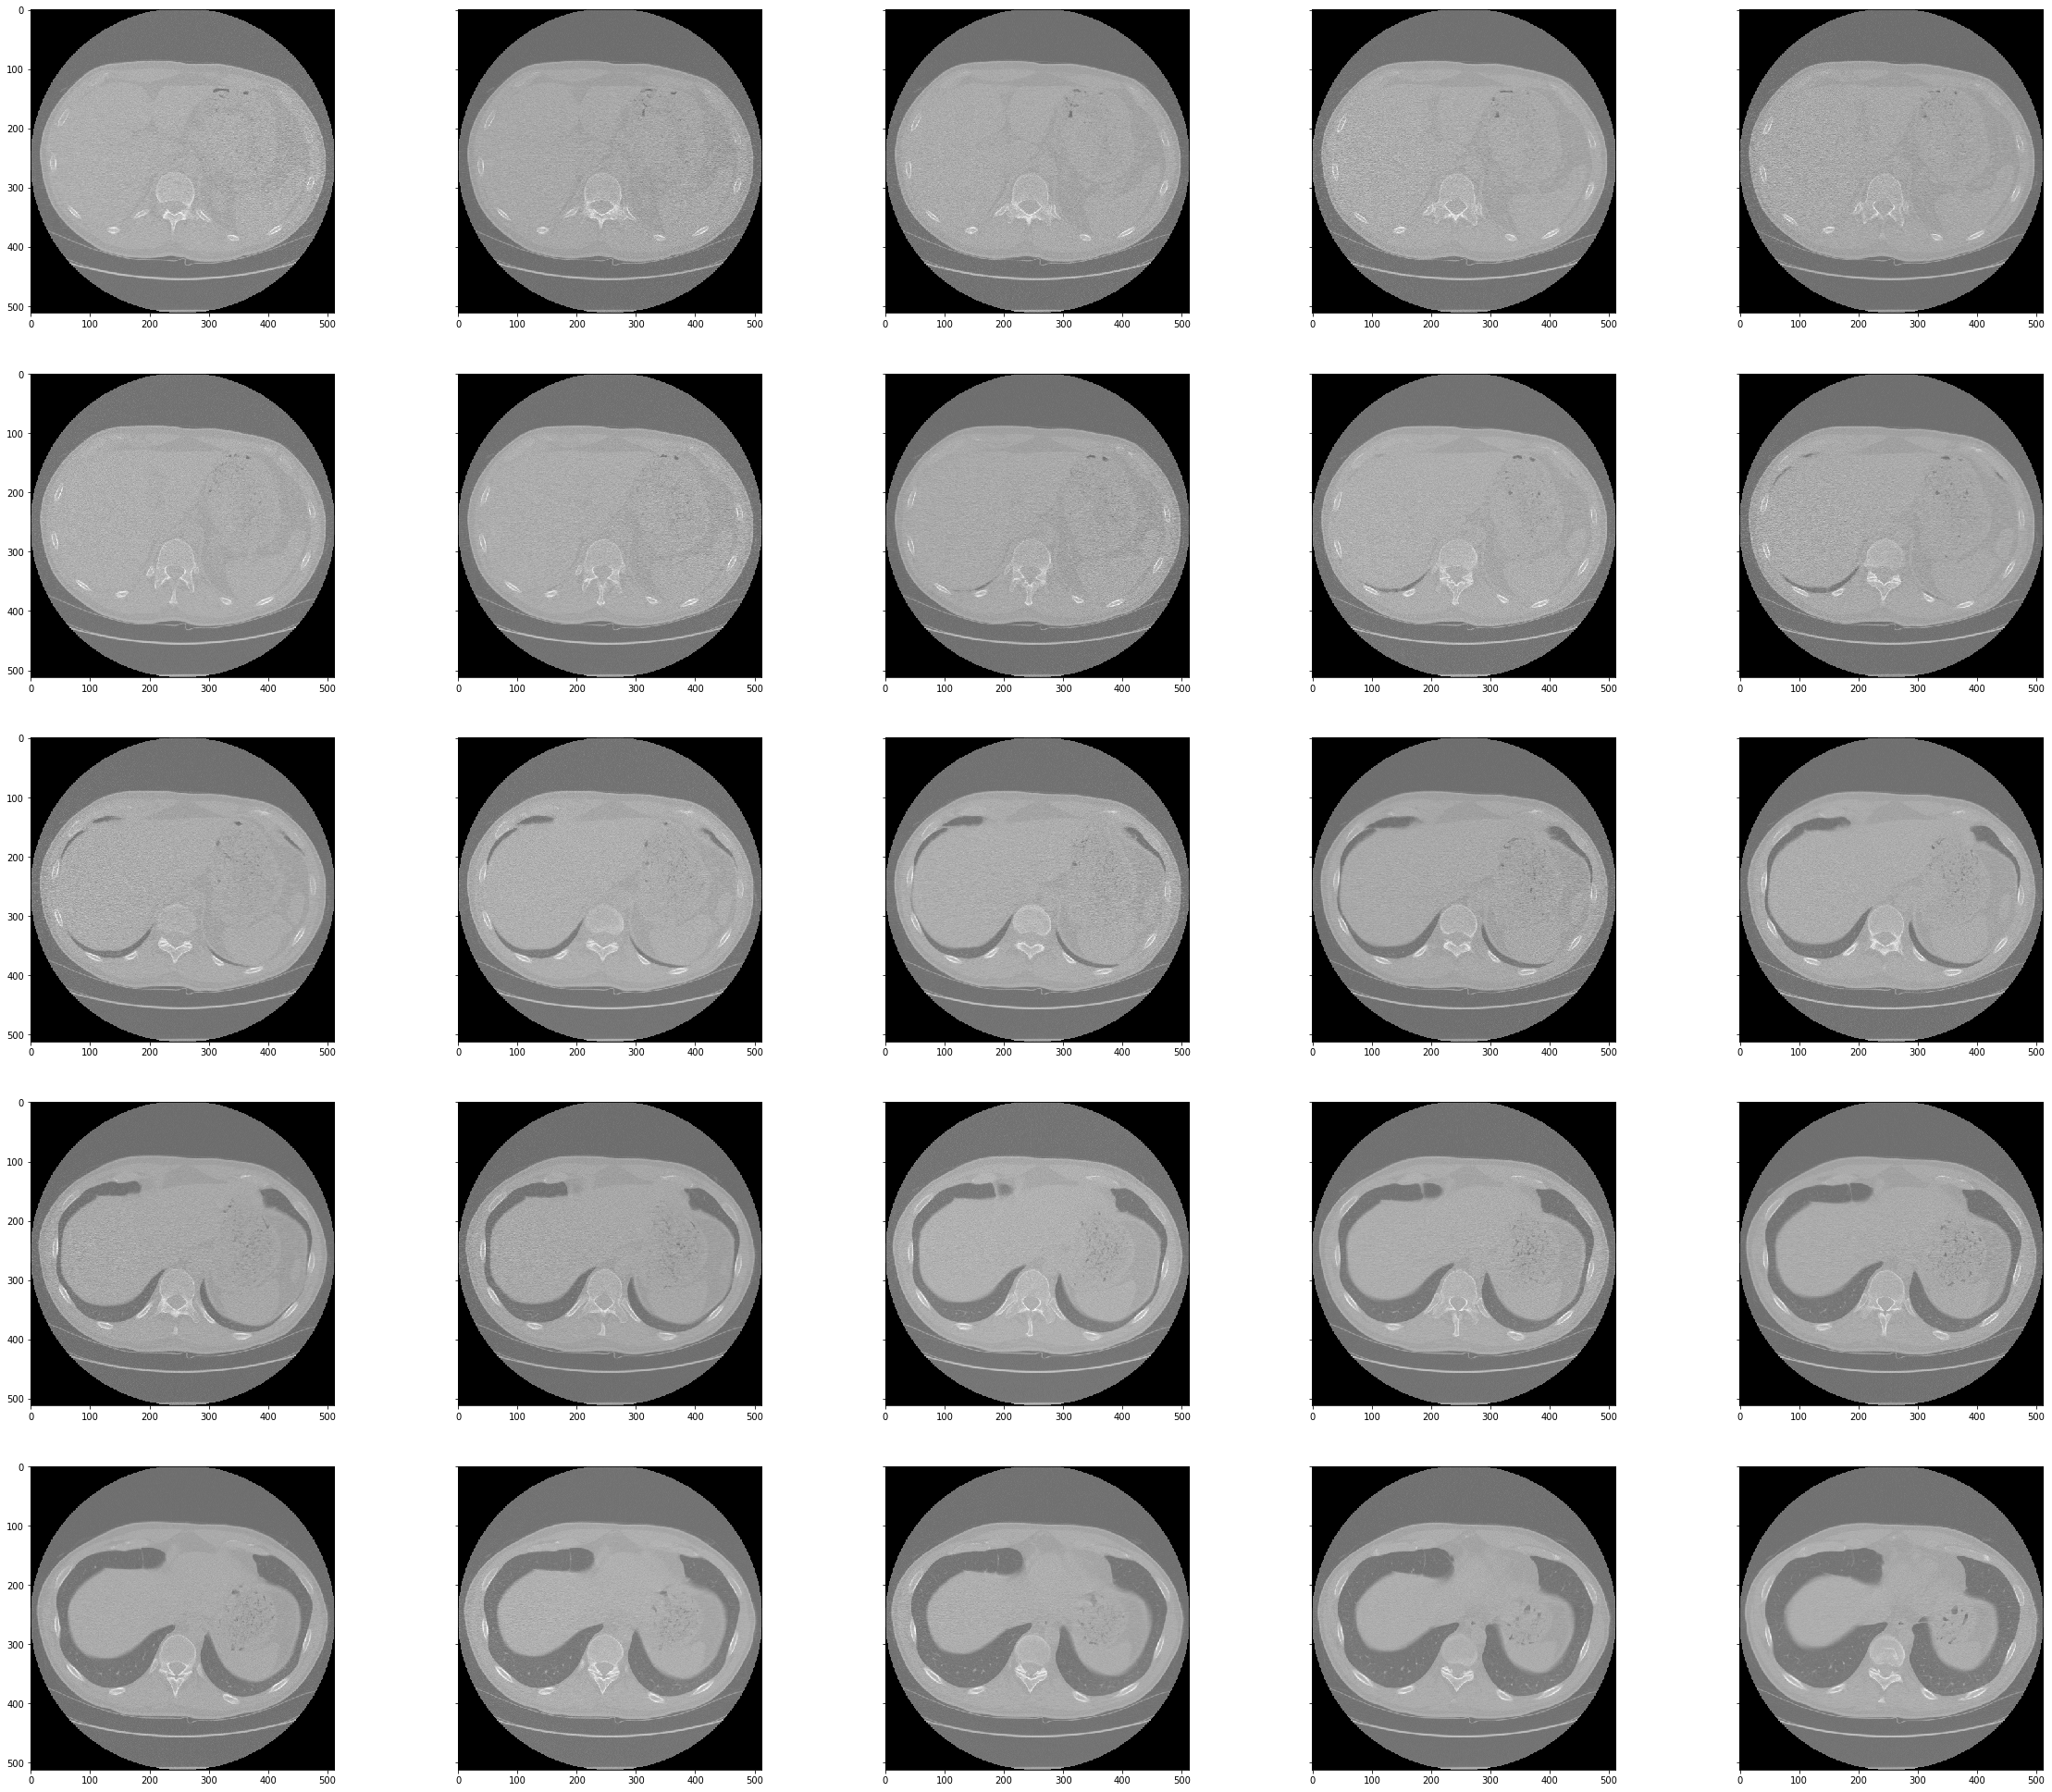

In [16]:
fig, axs = plt.subplots(5,5, figsize=(40, 35), sharey='row')
axs = axs.ravel()
for index, i in enumerate(range(0,25,1)):
    axs[index].imshow(load_itk_image(candidates[candidates['file_location'] != ''].iloc[0]['file_location'])[0][i], cmap=plt.cm.gray)
plt.show()

In [17]:
datapos = candidates[candidates['class']==1][candidates['file_location']!='']
dataneg = candidates[candidates['class']==0][candidates['file_location']!='']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [37]:
datapos.head()

,seriesuid,coordX,coordY,coordZ,class,file_location
15647,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,-100.460000,68.010000,-230.550000,1,subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.108...
16831,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,36.540000,78.100000,-122.920000,1,subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.109...
16978,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,44.250000,52.170000,-110.250000,1,subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.109...
17222,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,46.003141,47.665253,-108.482213,1,subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.109...
20044,1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...,136.310000,116.670000,-181.890000,1,subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.111...


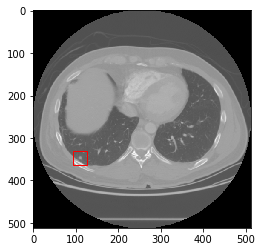

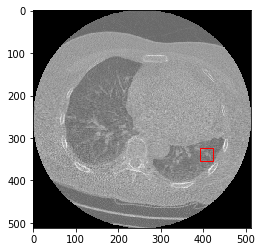

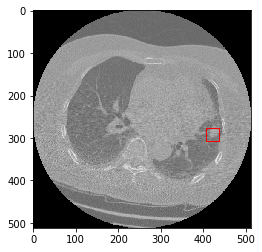

In [41]:
def plot_nodule(candidate):
    itk_img = sitk.ReadImage(candidate['file_location']) 
    img_array = sitk.GetArrayFromImage(itk_img)
    origin_xyz = np.array(itk_img.GetOrigin())   # x,y,z  Origin in world coordinates (mm)
    spacing_xyz = np.array(itk_img.GetSpacing()) # spacing of voxels in world coor. (mm)
    center_xyz = (candidate['coordX'], candidate['coordY'], candidate['coordZ'])
    nodule_xyz = ((center_xyz - origin_xyz) // spacing_xyz).astype(np.int16)

    fig, ax = plt.subplots(1)
    ax.imshow(img_array[nodule_xyz[2]], cmap=plt.cm.gray)
    ax.add_patch(
        patches.Rectangle(
            (nodule_xyz[0] - 16, nodule_xyz[1]-16),   # (x,y)
            32,          # width
            32,          # height
            linewidth=1, edgecolor='r', facecolor='none'
        )
    )

plot_nodule(datapos.iloc[0])
plot_nodule(datapos.iloc[1])
plot_nodule(datapos.iloc[2])

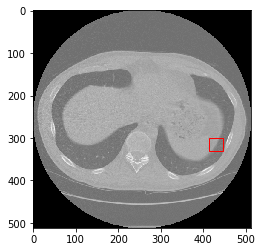

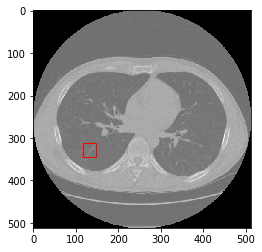

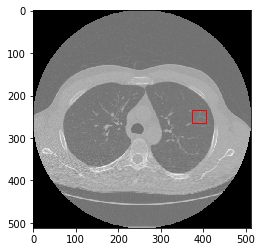

In [43]:
plot_nodule(dataneg.iloc[0])
plot_nodule(dataneg.iloc[1])
plot_nodule(dataneg.iloc[2])

In [56]:
def getdata(candidate):
    print('file name: ' + str(candidate['file_location']))
    itk_img = sitk.ReadImage(candidate['file_location']) 
    img_array = sitk.GetArrayFromImage(itk_img)  # z,y,x ordering
    print(np.array(img_array).shape)
    origin_xyz = np.array(itk_img.GetOrigin())   # x,y,z  Origin in world coordinates (mm)
    spacing_xyz = np.array(itk_img.GetSpacing()) # spacing of voxels in world coor. (mm)
    center_xyz = (candidate['coordX'], candidate['coordY'], candidate['coordZ'])
    nodule_xyz = ((center_xyz - origin_xyz) // spacing_xyz).astype(np.int16)
    ineed = img_array[nodule_xyz[2], nodule_xyz[1] - 16:nodule_xyz[1]+16, nodule_xyz[0] - 16:nodule_xyz[0]+16]
    ineed = np.array(ineed)
    return ineed

In [70]:
def getdata512(candidate):
    print('file name: ' + str(candidate['file_location']))
    itk_img = sitk.ReadImage(candidate['file_location']) 
    img_array = sitk.GetArrayFromImage(itk_img)
    return np.array(img_array)

In [57]:
for j in range(datapos.shape[0]):
    ineed = getdata(datapos.iloc[j])
    path = "data\\1" + "\\" + datapos.iloc[j][0]+str(datapos.iloc[j][1])+str(datapos.iloc[j][1])+str(datapos.iloc[j][2])+str(datapos.iloc[j][3])+".npy"
    np.save(path,ineed)
for j in range(dataneg.shape[0]):
    ineed = getdata(dataneg.iloc[j])
    path = "data\\0" + "\\" + dataneg.iloc[j][0]+str(dataneg.iloc[j][1])+str(dataneg.iloc[j][1])+str(dataneg.iloc[j][2])+str(dataneg.iloc[j][3])+".npy"
    np.save(path,ineed)

file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
(119, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
(161, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
(161, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
(161, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd
(538, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd
(195, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd
(672, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd
(133, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950.mhd
(483, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.1

(280, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.mhd
(109, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369979066736354549484.mhd
(176, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543.mhd
(280, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410.mhd
(733, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410.mhd
(733, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410.mhd
(733, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145.mhd
(129, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145.mhd
(129, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273.mhd
(147, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5

(121, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
(121, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
(121, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
(121, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
(121, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
(121, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
(121, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
(121, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
(121, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
(121, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5

(121, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
(121, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
(121, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
(121, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
(121, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
(121, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
(121, 512, 512)
file name: subset0\\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
(121, 512, 512)


In [ ]:
for j in range(datapos.shape[0]):
    ineed = getdata512(datapos.iloc[j])
    path = "data512\\1" + "\\" + datapos.iloc[j][0]+str(datapos.iloc[j][1])+str(datapos.iloc[j][1])+str(datapos.iloc[j][2])+str(datapos.iloc[j][3])+".npy"
    np.save(path,ineed)
for j in range(dataneg.shape[0]):
    ineed = getdata512(dataneg.iloc[j])
    path = "data512\\0" + "\\" + dataneg.iloc[j][0]+str(dataneg.iloc[j][1])+str(dataneg.iloc[j][1])+str(dataneg.iloc[j][2])+str(dataneg.iloc[j][3])+".npy"
    np.save(path,ineed)

In [67]:
glob.glob("data/*")

['data\\0', 'data\\1']

In [58]:
training_img = []
training_label = []
for dir_path in glob.glob("data/*"):
    print(dir_path)
    img_label = dir_path.split("\\")[-1]
    print(img_label)
    for image_path in glob.glob(os.path.join(dir_path,"*.npy")):
        image = np.load(image_path)
        training_img.append(image)
        training_label.append(img_label)
training_img = np.array(training_img)
training_label = np.array(training_label)

data\0
0
data\1
1


In [59]:
training_img.shape

(366, 32, 32)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(training_img, training_label, test_size=0.2, random_state=42)

In [66]:
X_train.shape

(292, 32, 32)

In [67]:
#tạo cnn model
batch_size = 64
num_classes = 2
epochs = 50

# input image dimensions
height, width = X_train.shape[1], X_train.shape[2]
input_shape = (height,width,1)

x_train = X_train.reshape(X_train.shape[0],  height, width, 1)
x_test = X_test.reshape(X_test.shape[0], height, width, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

limitbot = 1494
limittop = 4096
x_test[x_test>0]/=limittop
x_test[x_test<0]/=limitbot
x_train[x_train>0]/=limittop
x_train[x_train<0]/=limitbot


print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# chuyển sang onehot vector
y_train1h = keras.utils.to_categorical(y_train, num_classes)
y_test1h = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (292, 32, 32)
292 train samples
74 test samples


In [68]:
# Initialising the CNN
classifier = Sequential()
# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (height, width, 1), padding='same', use_bias=False))

#Set use_bias=False in layers.conv2d() and layers.dense() because BatchNormalization
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Conv2D(32, (3, 3), use_bias=False))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Conv2D(32, (3, 3), use_bias=False))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
# taking the 2-D array, i.e pooled image pixels and converting them to a one dimensional single vector.
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 256, kernel_initializer='he_normal', use_bias=False))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Dropout(0.25))
classifier.add(Dense(units = num_classes, activation = 'softmax', kernel_initializer='he_normal'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [69]:
classifier.fit(x_train, y_train1h,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(x_test, y_test1h))
score = classifier.evaluate(x_test, y_test1h, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
classes = classifier.predict_classes(x_test, batch_size = None)
print(classification_report(y_test, classes))

Train on 292 samples, validate on 74 samples
Epoch 1/50
292/292 [==============================] - 21s 73ms/step - loss: 0.6461 - acc: 0.7089 - val_loss: 0.4508 - val_acc: 0.7838
Epoch 2/50
292/292 [==============================] - 10s 33ms/step - loss: 0.2734 - acc: 0.8938 - val_loss: 0.4213 - val_acc: 0.7973
Epoch 3/50
292/292 [==============================] - 8s 28ms/step - loss: 0.1994 - acc: 0.9144 - val_loss: 0.4060 - val_acc: 0.8378
Epoch 4/50
292/292 [==============================] - 8s 26ms/step - loss: 0.1348 - acc: 0.9521 - val_loss: 0.4385 - val_acc: 0.8108
Epoch 5/50
292/292 [==============================] - 8s 26ms/step - loss: 0.0828 - acc: 0.9863 - val_loss: 0.4402 - val_acc: 0.7838
Epoch 6/50
292/292 [==============================] - 8s 27ms/step - loss: 0.0760 - acc: 0.9829 - val_loss: 0.4089 - val_acc: 0.8514
Epoch 7/50
292/292 [==============================] - 8s 26ms/step - loss: 0.0486 - acc: 0.9897 - val_loss: 0.4354 - val_acc: 0.8378
Epoch 8/50
292/292 [==

In [96]:
def inception(use_imagenet=True):
    # load pre-trained model graph, don't add final layer
    model = keras.applications.InceptionV3(include_top=False, input_shape=(32, 32, 1),
                                          weights='imagenet' if use_imagenet else None)
    # add global pooling just like in InceptionV3
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    # add new dense layer for our labels
    new_output = keras.layers.Dense(2, activation='softmax')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [97]:
model = inception()

ValueError: The input must have 3 channels; got `input_shape=(32, 32, 1)`